In [6]:
import numpy as np
import pandas as pd
import sys, os, time
main_folder = './../'
if main_folder not in sys.path:
    sys.path.append(main_folder)
from evolution import DifferentialEvolution
from glob       import glob
from tqdm       import tqdm

import dirs
from utils      import get_solution, ProgressBar, write_log
import matplotlib.pyplot as plt 

progbar = ProgressBar(elapsed_time=True)

### Parameters

In [2]:
# Competition Parameters
funcId      = 1
dim         = 10
numRuns     = 2
targetError = 1e-8

# Algorithm Parameters
pop_size = 300
percMaxEvals = 1
maxEvals = 'auto'
maxGenerations = None
fitness_clusters = None
crossover = 'binonial'
mutation = 'best'
n_diff = 1
lambda_mutation = .5
opposition = False
input_data_filepath = './../input_data'
active = False

In [3]:
maxEvals = maxEvals if percMaxEvals is None else percMaxEvals*10000*dim
run_tag = '[' + '_'.join([str(funcId), 
                          str(dim), 
                          str(numRuns),
                          str(pop_size), 
                          str(percMaxEvals),                                                     
                          '{}'.format(lambda_mutation), 
                          str(opposition),
                          str(fitness_clusters)
                         ])  + ']'
run_tag

'[1_10_2_300_1_0.5_False_None]'

In [10]:
alg = DifferentialEvolution(dim=dim, func_id=funcId, pop_size=pop_size, crossover=crossover, 
        opposition=opposition, mutation=mutation, lambda_mutation=.5, fitness_clusters=fitness_clusters)

output_filepath = os.path.join(dirs.results, str(alg))
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
output_filepath = output_filepath + '/' + run_tag

print ('Writing log at ', output_filepath + 'log.tsv')
write_log(filepath=output_filepath + 'log.tsv', 
          mode="w+", 
          text='[{}]\trun\telapsedTime\tsuccessRate\n'.format(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())))  

Writing log at  ./results/DE/best/1/bin/[1_10_2_300_1_0.5_False_None]log.tsv


In [13]:
hist = pd.DataFrame()
arr_runs = range(numRuns)
solution = get_solution(funcId, dim, input_data_filepath=input_data_filepath)
successRate = 0
for idx_run in arr_runs:
    progbar.update_progress(idx_run/float(len(arr_runs)))
    
    # Differential Evolution
    alg = DifferentialEvolution(dim=dim, func_id=funcId, pop_size=pop_size, crossover=crossover, 
        opposition=opposition, mutation=mutation, lambda_mutation=.5, fitness_clusters=fitness_clusters)
    
    errorHist, fitnessHist = alg.optimize(target=solution, max_f_evals=maxEvals, target_error=targetError, verbose=True)        
    bestError = errorHist.iloc[-1,:].min()
    errorHist["run"] = np.ones(errorHist.shape[0], dtype=int)*idx_run
    hist = pd.concat([hist, errorHist], ignore_index=False)    
    if bestError <= targetError:
        print ("Target error achieved with error {}".format(bestError))
        successRate += 1
    
    write_log(filepath=output_filepath + 'log.tsv', 
              text='[{}]\t{}/{}\t{}\t{}\n'.format(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()), 
                                              idx_run+1,
                                              len(arr_runs),
                                              progbar.get_elapsed_time(),
                                              successRate)
             )
    
hist.index.name = 'generation'
hist.to_csv(output_filepath + 'hist.tsv', sep='\t')
progbar.update_progress(1)

[0:00:00][----------] 0.00% Optimization ended due to max fitness evals (max = 100000, curr = 99900)

#Generations:	331
#FitnessEvals:	99900
Mean Fitness:	108.7750
Best Fitness:	101.2548
Solution:	100.0000
Diff:		1.2548
[0:02:22][#####-----] 50.00% Optimization ended due to max fitness evals (max = 100000, curr = 99900)

#Generations:	331
#FitnessEvals:	99900
Mean Fitness:	110.6572
Best Fitness:	102.3049
Solution:	100.0000
Diff:		2.3049
[0:04:45][##########] 100.00% Done...


In [14]:
print ("Elapsed Time: ", progbar.get_elapsed_time())

Elapsed Time:  0:04:45


In [15]:
errorHist.tail()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,run
generation,,,,,,,,,,,,,,,,,,,,,
326,14.875881,9.075979,5.590868,12.349594,5.618836,11.382662,9.44572,5.708685,11.412976,10.543052,...,13.566161,5.903511,15.613954,12.332765,8.141611,9.276734,13.519232,20.082359,7.036256,1
327,14.875881,9.075979,5.590868,9.749157,5.618836,10.677946,9.44572,5.708685,11.412976,5.380548,...,13.566161,5.903511,15.613954,12.332765,8.141611,9.276734,13.519232,20.082359,7.036256,1
328,14.875881,9.075979,5.590868,9.749157,5.618836,10.677946,5.51690,5.708685,11.412976,5.380548,...,13.566161,5.903511,15.613954,8.625658,3.748108,9.276734,13.519232,20.082359,7.036256,1
329,13.827464,9.075979,5.590868,9.749157,5.618836,10.677946,5.51690,5.708685,11.412976,5.380548,...,13.566161,5.903511,15.613954,5.027812,3.748108,9.276734,13.519232,18.516392,7.036256,1
330,13.827464,9.075979,4.670027,9.749157,5.618836,8.673390,5.51690,5.708685,11.412976,5.380548,...,13.566161,5.903511,15.613954,5.027812,3.748108,9.276734,10.580690,18.516392,7.036256,1


In [18]:
arr_error = list()
arr_best_error = list()
for run in hist['run'].unique():
    df_run = hist[hist['run'] == run].drop(['run'], axis=1) 
    bestError = df_run.iloc[-1,:].min()    
    arr_best_error.append(bestError)    
    print ('Best error for run {}: {}'.format(run, bestError))
    arr_error.append(np.array(df_run.min(axis=1)))    
arr_error = np.array(arr_error)
# arr_error

Best error for run 0: 1.2548340082144875
Best error for run 1: 2.304939732538898


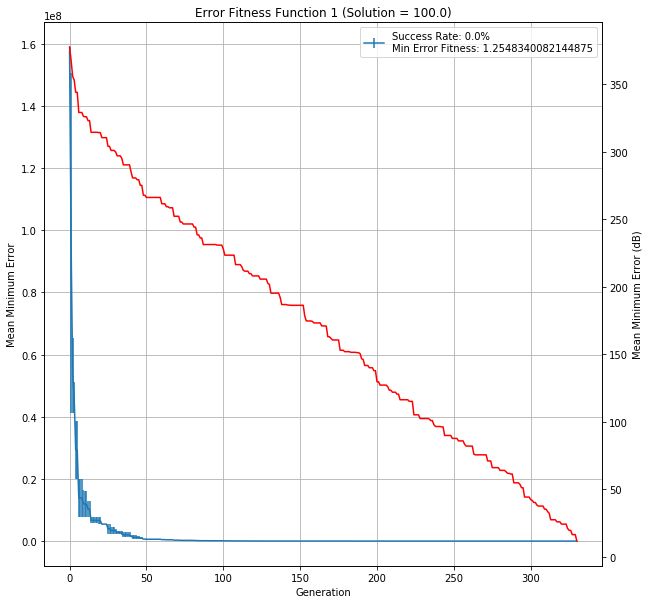

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
label = 'Success Rate: {}%\nMin Error Fitness: {}'.format(100*(successRate/float(numRuns)), arr_error.min())
ax.errorbar(np.arange(alg.generations), arr_error.mean(axis=0), yerr=arr_error.std(axis=0), label=label)
ax2 = ax.twinx()
ax2.plot(np.arange(alg.generations), 20*np.log(arr_error.mean(axis=0)), label='Mean Min Error (dB)', color='red')
ax2.set_ylabel('Mean Minimum Error (dB)')

ax.grid(True)
ax.set_ylabel('Mean Minimum Error')
ax.legend()
ax.set_xlabel('Generation')
ax.set_title('Error Fitness Function {} (Solution = {})'.format(funcId, solution))
plt.savefig(output_filepath + 'mean_error_evolution.jpeg', bbox_inches = 'tight')

In [23]:
df_sumup = pd.DataFrame(columns=['algorithm', '#Fc', 'D', 'percFES'] + ['run_' + str(i) for i in np.arange(1,numRuns+1,1)] + ['mean', 'elapsed_time', 'evals'])
df_sumup.loc[df_sumup.shape[0]] = [str(alg), funcId, dim, percMaxEvals] + arr_best_error + [np.mean(arr_best_error), progbar.get_elapsed_time(), alg.fitnessEvals]
print ('Saving df_sumup to ', output_filepath + 'df_sumup.tsv')
df_sumup.to_csv(output_filepath + 'df_sumup.tsv', sep='\t')
df_sumup

Saving df_sumup to  ./results/DE/best/1/bin/[1_10_2_300_1_0.5_False_None]df_sumup.tsv


,algorithm,#Fc,D,percFES,run_1,run_2,mean,elapsed_time,evals
0,DE/best/1/bin,1,10,1,1.254834,2.30494,1.779887,0:04:45,99900
